In [19]:
import os
import pandas as pd
import numpy as np
from glob import glob

# Function to calculate z-scores with special handling for zero entries
def calculate_z_scores(data):
    # Exclude zeros when calculating mean and standard deviation
    mean = np.mean(data[data != 0])
    std = np.std(data[data != 0])

    # Avoid division by zero in case all non-zero values are the same
    if std == 0:
        return np.zeros_like(data)  # Return all zeros if standard deviation is zero

    # Calculate z-scores for non-zero values
    z_scores = (data - mean) / std
    z_scores[data == 0] = 0  # Keep zeros as zero
    return z_scores

# Path to folder with patient CSV files
data_folder = r'C:\Users\sejac\Desktop\BIEN471\csv_labels'  # Replace with your actual directory path
file_paths = glob(os.path.join(data_folder, '*.csv'))

# Lists to store data for each patient and their labels
patient_data = []
patient_labels = []

# Process each file
for file_path in file_paths:
    # Extract the filename from the path and get the label based on '_0' or '_1' in the filename
    file_name = os.path.basename(file_path)
    label = 1 if '_1' in file_name else 0

    # Load the CSV file
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        continue

    # Ensure the required column exists
    if 'Percent_Methylation' not in df.columns:
        print(f"Missing 'Percent_Methylation' in {file_path}. Skipping.")
        continue

    # Get the Percent_Methylation column
    percent_methylation = df['Percent_Methylation'].values

    # Check for consistent data length
    if len(percent_methylation) != 100017:  # Replace with your expected length
        print(f"Inconsistent data length in {file_name}. Skipping.")
        continue

    # Normalize using z-scores while keeping zeros unchanged
    normalized_data = calculate_z_scores(percent_methylation)

    # Append normalized data and label
    patient_data.append(normalized_data)
    patient_labels.append(label)

# Convert lists to numpy arrays for modeling
X = np.array(patient_data)  # Shape should be (num_patients, num_bins)
y = np.array(patient_labels)  # Shape should be (num_patients,)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


Data shape: (517, 100017), Labels shape: (517,)


In [20]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(517, 100017)
(517,)
[[-0.11970948  1.05177586  1.05177586 ... -2.46268015  0.
   0.        ]
 [ 0.          0.13412028 -1.63022517 ...  0.          0.
   0.        ]
 [ 0.          0.80735157 -0.542742   ... -2.61981325  0.
   0.        ]
 ...
 [-1.54023988  1.10698546  0.         ...  0.         -1.54023988
  -2.4226501 ]
 [ 0.0285625  -1.5074172   0.         ...  1.05254896  1.05254896
   0.32113079]
 [ 1.05492582  1.05492582  1.05492582 ...  1.05492582 -1.71454434
   0.        ]]
[0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 

# **Actual Model**

In [21]:
import torch
import torch.nn as nn

class SparseConnectionLayer(nn.Module):
    def __init__(self, input_size, output_size, connections_per_output):
        """
        Custom sparse layer with localized sparse connections.
        Args:
            input_size: Total number of neurons in the input layer.
            output_size: Total number of neurons in the output layer.
            connections_per_output: Number of input neurons connected to each output neuron.
        """
        super(SparseConnectionLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.connections_per_output = connections_per_output

        # Predefine sparse connectivity
        self.connections = self._generate_connections()

        # Parameters: weights and biases for each output neuron
        self.weights = nn.Parameter(torch.randn(output_size, connections_per_output))
        self.bias = nn.Parameter(torch.zeros(output_size))

    def _generate_connections(self):
        """
        Generate a fixed sparse connection pattern.
        Returns:
            A list of input neuron indices for each output neuron.
        """
        connections = []
        for i in range(self.output_size):
            # Select `connections_per_output` input neurons for each output neuron
            start_idx = (i * self.connections_per_output) % self.input_size
            connections.append(
                [(start_idx + j) % self.input_size for j in range(self.connections_per_output)]
            )
        return connections

    def forward(self, x):
        """
        Forward pass with sparse connections.
        Args:
            x: Input tensor of shape [batch_size, input_size].
        Returns:
            Tensor of shape [batch_size, output_size].
        """
        batch_size = x.size(0)
        output = []
        device = x.device  # Ensure all tensors are on the same device
    
        for i, indices in enumerate(self.connections):
            # Ensure indices are on the same device as input
            indices = torch.tensor(indices, device=device)
    
            # Select the relevant input neurons for the current output neuron
            input_subset = x[:, indices]  # Shape: [batch_size, connections_per_output]
    
            # Ensure weights and biases are on the correct device
            weights = self.weights[i].to(device)
            bias = self.bias[i].to(device)
    
            # Compute weighted sum for this sparse connection
            weighted_sum = torch.matmul(input_subset, weights) + bias
            output.append(weighted_sum)
    
        return torch.stack(output, dim=1)  # Shape: [batch_size, output_size]


class CancerPredictionModel(nn.Module):
    def __init__(self):
        super(CancerPredictionModel, self).__init__()
        # Define sparse layers
        self.hidden1 = SparseConnectionLayer(input_size=100017, output_size=33339, connections_per_output=3)
        self.hidden2 = SparseConnectionLayer(input_size=33339, output_size=11113, connections_per_output=3)
        self.hidden3 = SparseConnectionLayer(input_size=11113, output_size=3704, connections_per_output=3)
        self.hidden4 = SparseConnectionLayer(input_size=3704, output_size=1234, connections_per_output=3)
        self.hidden5 = SparseConnectionLayer(input_size=1234, output_size=411, connections_per_output=3)
        self.hidden6 = SparseConnectionLayer(input_size=411, output_size=137, connections_per_output=3)
        self.hidden7 = SparseConnectionLayer(input_size=137, output_size=45, connections_per_output=3)

        # Fully connected layers
        self.fc1 = nn.Linear(45, 15)  # Fully connected layer (45 -> 15)
        self.fc2 = nn.Linear(15, 5)   # Fully connected layer (15 -> 5)
        self.fc3 = nn.Linear(5, 1)    # Fully connected layer (5 -> 1)

        # Bias-fixing neuron (final adjustment layer)
        self.bias_fixer = nn.Linear(1, 1, bias=False)  # Linear neuron for bias adjustment

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass through sparse layers
        x = self.hidden1(x)
        x = self.relu(x)

        x = self.hidden2(x)
        x = self.relu(x)

        x = self.hidden3(x)
        x = self.relu(x)

        x = self.hidden4(x)
        x = self.relu(x)

        x = self.hidden5(x)
        x = self.relu(x)

        x = self.hidden6(x)
        x = self.relu(x)

        x = self.hidden7(x)
        x = self.relu(x)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)

        # Bias-fixing adjustment
        x = self.bias_fixer(x)

        # Final sigmoid activation for binary classification
        x = self.sigmoid(x)
        return x


In [22]:
# Define the model
model = CancerPredictionModel()

input_data = torch.randn(4, 100017)  # Shape: [batch_size, input_size]

# Forward pass
output = model(input_data)
print(output)  # Output probabilities for "cancer" (1) or "not cancer" (0)

tensor([[0.5010],
        [0.4998],
        [0.5016],
        [0.5007]], grad_fn=<SigmoidBackward0>)


In [23]:
# Convert the numpy arrays X and y into PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Input data tensor
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Labels tensor (reshape to match output)

print(X_tensor)
print(y_tensor)

tensor([[-0.1197,  1.0518,  1.0518,  ..., -2.4627,  0.0000,  0.0000],
        [ 0.0000,  0.1341, -1.6302,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.8074, -0.5427,  ..., -2.6198,  0.0000,  0.0000],
        ...,
        [-1.5402,  1.1070,  0.0000,  ...,  0.0000, -1.5402, -2.4227],
        [ 0.0286, -1.5074,  0.0000,  ...,  1.0525,  1.0525,  0.3211],
        [ 1.0549,  1.0549,  1.0549,  ...,  1.0549, -1.7145,  0.0000]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [24]:
# Pick a seed
torch.manual_seed(38)

# Instantiate the model
model = CancerPredictionModel()

In [25]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=38, shuffle=True
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Labels need to be 2D
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the criterion (loss function) and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Display the shapes of the training and testing data for verification
#print("Training data shape:", X_train_tensor.shape)
#print("Testing data shape:", X_test_tensor.shape)
#print("Training labels shape:", y_train_tensor.shape)
#print("Testing labels shape:", y_test_tensor.shape)
#print("Training data:", X_train_tensor)
#print("Testing data shape:", X_test_tensor)
#print("Training labels shape:", y_train_tensor)
#print("Testing labels shape:", y_test_tensor)

# Print the initialized optimizer and criterion
print("Optimizer:", optimizer)
print("Criterion:", criterion)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Criterion: BCELoss()


In [26]:
import torch

# Check if GPU is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found")

# Move model to GPU
model = model.to(device)

# Move data to GPU
X_train_tensor = X_train_tensor.to(device)  # Ensure input is on the GPU
y_train_tensor = y_train_tensor.to(device)  # Ensure labels are on the GPU


GPU available: True
Device name: NVIDIA GeForce RTX 3060


In [27]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    # Inside the training loop, after loss.backward():
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            print(f"Gradient Norm for {name}: {param.grad.norm().item():.6f}")

    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        probabilities = torch.sigmoid(outputs)  # Convert raw logits to probabilities
        predictions = probabilities > 0.6  # Apply threshold for predictions
        correct = (predictions == y_train_tensor).sum().item()
        accuracy = correct / y_train_tensor.size(0)

    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Print loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {accuracy * 100:.2f}%")

    # Print predictions and probabilities (for the first 50 samples)
    print("Sample Predictions and Probabilities (First 50 Samples):")
    print(f"Probabilities: {probabilities[:50].cpu().numpy().flatten()}")
    print(f"Predictions: {predictions[:50].cpu().numpy().astype(int).flatten()}")


Gradient Norm for hidden1.weights: 0.003620
Gradient Norm for hidden1.bias: 0.001970
Gradient Norm for hidden2.weights: 0.004649
Gradient Norm for hidden2.bias: 0.001874
Gradient Norm for hidden3.weights: 0.003152
Gradient Norm for hidden3.bias: 0.001212
Gradient Norm for hidden4.weights: 0.002034
Gradient Norm for hidden4.bias: 0.000801
Gradient Norm for hidden5.weights: 0.003220
Gradient Norm for hidden5.bias: 0.001106
Gradient Norm for hidden6.weights: 0.008904
Gradient Norm for hidden6.bias: 0.000876
Gradient Norm for hidden7.weights: 0.002797
Gradient Norm for hidden7.bias: 0.000575
Gradient Norm for fc1.weight: 0.021645
Gradient Norm for fc1.bias: 0.000838
Gradient Norm for fc2.weight: 0.008790
Gradient Norm for fc2.bias: 0.001649
Gradient Norm for fc3.weight: 0.004427
Gradient Norm for fc3.bias: 0.010379
Gradient Norm for bias_fixer.weight: 0.007125
Epoch [1/10], Loss: 0.6891, Training Accuracy: 46.01%
Sample Predictions and Probabilities (First 50 Samples):
Probabilities: [0.60

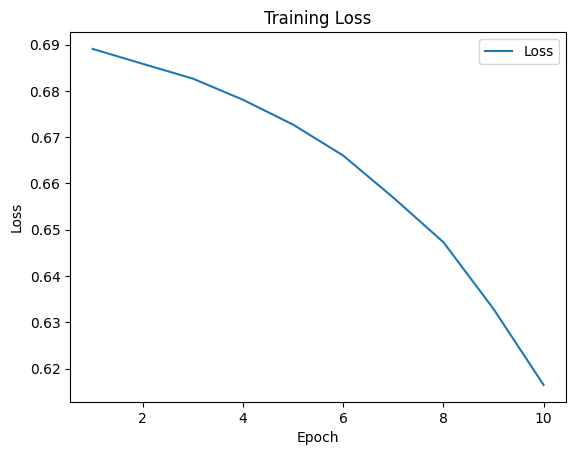

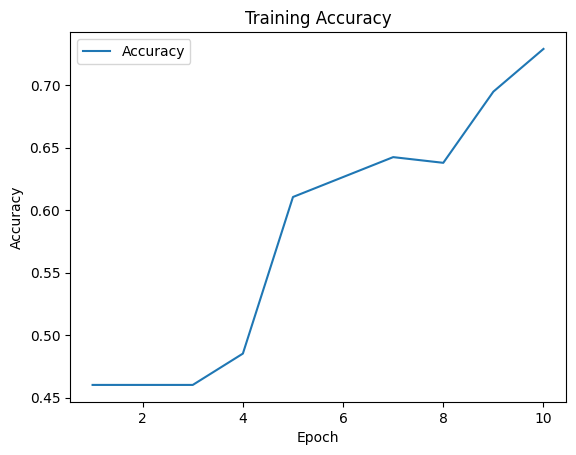

In [28]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Move model to the appropriate device (already done in your code)
model = model.to(device)

# Move test data to the same device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Ensure model is in evaluation mode
    model.eval()
    
    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Forward pass
        outputs = model(X_test)
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
        predictions = (probabilities > threshold).float()  # Threshold for binary predictions

        # Move tensors back to CPU if using GPU
        y_test_cpu = y_test.cpu().numpy()
        probabilities_cpu = probabilities.cpu().numpy().flatten()
        predictions_cpu = predictions.cpu().numpy().flatten()
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test_cpu, predictions_cpu)
        auc = roc_auc_score(y_test_cpu, probabilities_cpu)
        precision = precision_score(y_test_cpu, predictions_cpu)
        recall = recall_score(y_test_cpu, predictions_cpu)
        f1 = f1_score(y_test_cpu, predictions_cpu)

    return {
        "Accuracy": accuracy,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [31]:
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
metrics = evaluate_model(model, X_test_tensor, y_test_tensor, threshold=0.6)
print("Evaluation Metrics on Test Set:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics on Test Set:
Accuracy: 0.4872
AUC: 0.5586
Precision: 0.4800
Recall: 0.6316
F1 Score: 0.5455


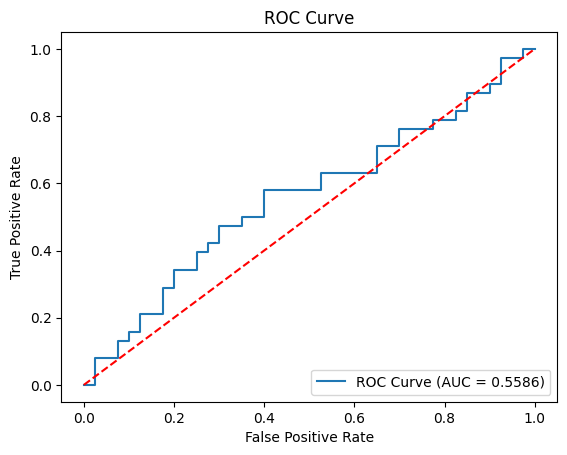

In [34]:
from sklearn.metrics import roc_curve

# Calculate probabilities
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu().numpy(), probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
